In [1]:
!pip install torchtext==0.8.1

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.0/7.0 MB 28.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 776.8/776.8 MB 1.4 MB/s eta 0:00:00
  Attempting uninstall: torch
    Found existing installation: torch 1.13.1+cu116
    Uninstalling torch-1.13.1+cu116:
      Successfully uninstalled torch-1.13.1+cu116
  Attempting uninstall: torchtext
    Found existing installation: torchtext 0.14.1
    Uninstalling torchtext-0.14.1:
      Successfully uninstalled torchtext-0.14.1
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
torchvision 0.14.1+cu116 requires torch==1.13.1, but you have torch 1.7.1 which is incompatible.
torchaudio 0.13.1+cu116 requires torch==1.13.1, but you have torch 1.7.1 which is incompatible.


In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchtext.data as ttd
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime

In [3]:
!wget -nc https://lazyprogrammer.me/course_files/spam.csv

--2023-02-21 01:42:03--  https://lazyprogrammer.me/course_files/spam.csv
Resolving lazyprogrammer.me (lazyprogrammer.me)... 104.21.23.210, 172.67.213.166, 2606:4700:3031::6815:17d2, ...
Connecting to lazyprogrammer.me (lazyprogrammer.me)|104.21.23.210|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 503663 (492K) [text/csv]
Saving to: ‘spam.csv’

spam.csv            100%[===================>] 491.86K  1.71MB/s    in 0.3s    

2023-02-21 01:42:04 (1.71 MB/s) - ‘spam.csv’ saved [503663/503663]



In [4]:
df = pd.read_csv('spam.csv', encoding='ISO-8859-1')

In [5]:
df.head()

,v1,v2,Unnamed: 2,Unnamed: 3,Unnamed: 4
0,ham,"Go until jurong point, crazy.. Available only ...",NaN,NaN,NaN
1,ham,Ok lar... Joking wif u oni...,NaN,NaN,NaN
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,NaN,NaN,NaN
3,ham,U dun say so early hor... U c already then say...,NaN,NaN,NaN
4,ham,"Nah I don't think he goes to usf, he lives aro...",NaN,NaN,NaN


In [6]:
# drop unnecessary columns
df = df.drop(["Unnamed: 2", "Unnamed: 3", "Unnamed: 4"], axis=1)

In [7]:
df.head()

,v1,v2
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


In [8]:
# rename columns to something better
df.columns = ['labels', 'data']

In [9]:
df.head()

,labels,data
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


In [10]:
# create binary labels
df['b_labels'] = df['labels'].map({'ham': 0, 'spam': 1})

In [11]:
df2 = df[['data', 'b_labels']]

In [12]:
df2.head()

,data,b_labels
0,"Go until jurong point, crazy.. Available only ...",0
1,Ok lar... Joking wif u oni...,0
2,Free entry in 2 a wkly comp to win FA Cup fina...,1
3,U dun say so early hor... U c already then say...,0
4,"Nah I don't think he goes to usf, he lives aro...",0


In [13]:
df2.to_csv('spam2.csv', index=False)

In [14]:
TEXT = ttd.Field(sequential=True, batch_first=True, lower=False, pad_first=True)
LABEL = ttd.Field(sequential=False, use_vocab=False, is_target=True)

dataset = ttd.TabularDataset(
    path="spam2.csv",
    format="csv",
    skip_header=True,
    fields=[("data", TEXT), ("label", LABEL)]
)

/usr/local/lib/python3.8/dist-packages/torchtext/data/field.py:150: UserWarning: Field class will be retired soon and moved to torchtext.legacy. Please see the most recent release notes for further information.
  warnings.warn('{} class will be retired soon and moved to torchtext.legacy. Please see the most recent release notes for further information.'.format(self.__class__.__name__), UserWarning)
/usr/local/lib/python3.8/dist-packages/torchtext/data/example.py:68: UserWarning: Example class will be retired soon and moved to torchtext.legacy. Please see the most recent release notes for further information.
  warnings.warn('Example class will be retired soon and moved to torchtext.legacy. Please see the most recent release notes for further information.', UserWarning)
/usr/local/lib/python3.8/dist-packages/torchtext/data/example.py:78: UserWarning: Example class will be retired soon and moved to torchtext.legacy. Please see the most recent release notes for further information.
  warn

In [15]:
train_dataset, test_dataset = dataset.split()

In [16]:
TEXT.build_vocab(train_dataset)

In [17]:
vocab = TEXT.vocab

In [18]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cpu


In [22]:
train_iter, test_iter = ttd.Iterator.splits((train_dataset, test_dataset), sort_key=lambda x: len(x.data), batch_sizes=(32, 256), device=device)

/usr/local/lib/python3.8/dist-packages/torchtext/data/iterator.py:48: UserWarning: Iterator class will be retired soon and moved to torchtext.legacy. Please see the most recent release notes for further information.
  warnings.warn('{} class will be retired soon and moved to torchtext.legacy. Please see the most recent release notes for further information.'.format(self.__class__.__name__), UserWarning)


In [23]:
embed = nn.Embedding(len(vocab), 20).to(device)
for inputs, targets in train_iter:
  out = embed(inputs)
  print(f"Input Shape: {inputs.shape}, Output Shape: {out.shape}")
  break

Input Shape: torch.Size([32, 70]), Output Shape: torch.Size([32, 70, 20])


/usr/local/lib/python3.8/dist-packages/torchtext/data/batch.py:23: UserWarning: Batch class will be retired soon and moved to torchtext.legacy. Please see the most recent release notes for further information.
  warnings.warn('{} class will be retired soon and moved to torchtext.legacy. Please see the most recent release notes for further information.'.format(self.__class__.__name__), UserWarning)


In [24]:
# Define the model
class CNN(nn.Module):
  def __init__(self, n_vocab, embed_dim, n_outputs):
    super(CNN, self).__init__()
    self.V = n_vocab
    self.D = embed_dim
    self.K = n_outputs

    # if input is T words
    # then output is T x D matrix
    self.embed = nn.Embedding(self.V, self.D)

    # conv layers
    self.conv1 = nn.Conv1d(self.D, 32, 3, padding=1)
    self.pool1 = nn.MaxPool1d(2)
    self.conv2 = nn.Conv1d(32, 64, 3, padding=1)
    self.pool2 = nn.MaxPool1d(2)
    self.conv3 = nn.Conv1d(64, 128, 3, padding=1)

    self.fc = nn.Linear(128, self.K)

  def forward(self, X):
    # embedding layer
    # turn word indexes into word vectors
    out = self.embed(X)

    # Note: output of embedding is always N x T x D
    # Conv1d expects N x D x T

    # conv layers
    out = out.permute(0, 2, 1)
    out = self.conv1(out)
    out = F.relu(out)
    out = self.pool1(out)
    out = self.conv2(out)
    out = F.relu(out)
    out = self.pool2(out)
    out = self.conv3(out)
    out = F.relu(out)

    # change it back
    out = out.permute(0, 2, 1)

    # max pool
    out, _ = torch.max(out, 1)

    # final dense layer
    out = self.fc(out)
    return out

In [25]:
model = CNN(len(vocab), 20, 1)
model.to(device)

CNN(
  (embed): Embedding(12484, 20)
  (conv1): Conv1d(20, 32, kernel_size=(3,), stride=(1,), padding=(1,))
  (pool1): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv1d(32, 64, kernel_size=(3,), stride=(1,), padding=(1,))
  (pool2): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv3): Conv1d(64, 128, kernel_size=(3,), stride=(1,), padding=(1,))
  (fc): Linear(in_features=128, out_features=1, bias=True)
)

In [26]:
# Loss and Optimizer
criterion = nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(model.parameters())

In [27]:
# A function to encapsulate the training loop
def batch_gd(model, criterion, optimizer, train_iter, test_iter, epochs):
  train_losses = np.zeros(epochs)
  test_losses = np.zeros(epochs)

  for it in range(epochs):
    t0 = datetime.now()
    train_loss = []
    for inputs, targets in train_iter:
      # print("inputs.shape:", inputs.shape, "targets.shape:", targets.shape)
      targets = targets.view(-1, 1).float()
      # move data to GPU
      # inputs, targets = inputs.to(device), targets.to(device)

      # zero the parameter gradients
      optimizer.zero_grad()

      # Forward pass
      outputs = model(inputs)
      # print("outputs.shape:", outputs.shape)
      loss = criterion(outputs, targets)
        
      # Backward and optimize
      loss.backward()
      optimizer.step()

      train_loss.append(loss.item())

    # Get train loss and test loss
    train_loss = np.mean(train_loss) # a little misleading
    
    test_loss = []
    for inputs, targets in test_iter:
      # inputs, targets = inputs.to(device), targets.to(device)
      targets = targets.view(-1, 1).float()
      outputs = model(inputs)
      loss = criterion(outputs, targets)
      test_loss.append(loss.item())
    test_loss = np.mean(test_loss)

    # Save losses
    train_losses[it] = train_loss
    test_losses[it] = test_loss
    
    dt = datetime.now() - t0
    print(f'Epoch {it+1}/{epochs}, Train Loss: {train_loss:.4f}, \
      Test Loss: {test_loss:.4f}, Duration: {dt}')
  
  return train_losses, test_losses

In [28]:
train_losses, test_losses = batch_gd(
    model, criterion, optimizer, train_iter, test_iter, 8)

/usr/local/lib/python3.8/dist-packages/torchtext/data/batch.py:23: UserWarning: Batch class will be retired soon and moved to torchtext.legacy. Please see the most recent release notes for further information.
  warnings.warn('{} class will be retired soon and moved to torchtext.legacy. Please see the most recent release notes for further information.'.format(self.__class__.__name__), UserWarning)


Epoch 1/8, Train Loss: 0.4060,       Test Loss: 0.4631, Duration: 0:00:03.918520
Epoch 2/8, Train Loss: 0.3023,       Test Loss: 0.3399, Duration: 0:00:02.029742
Epoch 3/8, Train Loss: 0.1746,       Test Loss: 0.2101, Duration: 0:00:02.001494
Epoch 4/8, Train Loss: 0.1111,       Test Loss: 0.1807, Duration: 0:00:02.066868
Epoch 5/8, Train Loss: 0.0730,       Test Loss: 0.1852, Duration: 0:00:02.053522
Epoch 6/8, Train Loss: 0.0516,       Test Loss: 0.1579, Duration: 0:00:02.615449
Epoch 7/8, Train Loss: 0.0391,       Test Loss: 0.1915, Duration: 0:00:02.984609
Epoch 8/8, Train Loss: 0.0247,       Test Loss: 0.1935, Duration: 0:00:02.059625


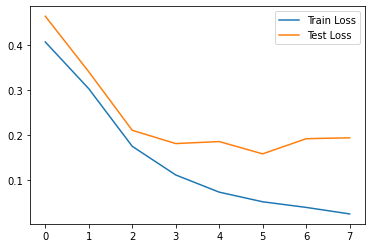

In [30]:
# Plot the train loss and test loss per iteration
plt.plot(train_losses, label='Train Loss')
plt.plot(test_losses, label='Test Loss')
plt.legend();

In [31]:
# Accuracy
n_correct = 0.
n_total = 0.

for inputs, targets in train_iter:
  targets = targets.view(-1, 1).float()
  
  # Forward Pass
  outputs = model(inputs)

  # Get Predictions
  predictions = (outputs > 0)

  # Update Counts
  n_correct += (predictions == targets).sum().item()
  n_total += targets.shape[0]

train_acc = n_correct / n_total

n_correct = 0.
n_total = 0.

for inputs, targets in test_iter:
  targets = targets.view(-1, 1).float()
  
  # Forward Pass
  outputs = model(inputs)

  # Get Predictions
  predictions = (outputs > 0)

  # Update Counts
  n_correct += (predictions == targets).sum().item()
  n_total += targets.shape[0]

test_acc = n_correct / n_total

print(f"Train acc: {train_acc:.4f}, Test acc: {test_acc:.4f}")

/usr/local/lib/python3.8/dist-packages/torchtext/data/batch.py:23: UserWarning: Batch class will be retired soon and moved to torchtext.legacy. Please see the most recent release notes for further information.
  warnings.warn('{} class will be retired soon and moved to torchtext.legacy. Please see the most recent release notes for further information.'.format(self.__class__.__name__), UserWarning)


Train acc: 0.9969, Test acc: 0.9330
